# Support Vector Machines
## Excerscise H8.2 C-SVM with std.  parameters

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import math
import scipy.stats as scp
import matplotlib as mpl
from numpy import linalg as la
from numpy import random as rand
from matplotlib import pyplot as plt
from sklearn import svm

In [2]:
def create_data(N):
    n = N/2
    n1 = (np.sign(rand.uniform(-1, 1, n))==1).sum()
    n2 = (np.sign(rand.uniform(-1, 1, n))==1).sum()

    X_c1 = np.append(rand.multivariate_normal([0,1], [[0.1, 0], [0, 0.1]], n1), rand.multivariate_normal([1,0], [[0.1, 0], [0, 0.1]], n-n1), axis=0)
    X_c2 = np.append(rand.multivariate_normal([0,0], [[0.1, 0], [0, 0.1]], n2), rand.multivariate_normal([1,1], [[0.1, 0], [0, 0.1]], n-n2), axis=0)
    # create a data matrix of shape 120x3 where colums 0 and 1 are the dimensions and colum 2 being the label
    p = np.vstack((X_c1, X_c2))
    #print p.shape
    y = np.vstack((np.zeros((n,1)), np.ones((n,1))))

    return p,y

In [3]:
def plot_data(X,y):
    N = len(X[:,0])
    n = N/2
    plt.scatter(X[0:n,0], X[0:n,1], color ='red')
    plt.scatter(X[n+1:N,0], X[n+1:N,1], color='black')

In [4]:
def grid_plot_svm (X,y,grid_size,r1,r2,plot_test=False, Xt=0, yt=0):
    # create a grid for the contour plot
    ran = np.linspace(r1, r2, grid_size)
    GX, GY = np.meshgrid(ran, ran)
    classes = np.zeros((grid_size, grid_size))
    c_svm = svm.SVC()
    c_svm.fit(X,y)

    # go through grid and compute the assigned class
    for gx in range(grid_size):
        for gy in range(grid_size):
            loc = np.vstack((ran[gx],ran[gy])).T
            classes[gx,gy] = c_svm.predict(loc)


    plt.figure()
    plt.contourf(GX, GY, classes[:,:].T, levels=[-1.0,0.,1.0])
    if(plot_test):
        N = len(Xt[:,0])
        n = N/2
        plt.scatter(Xt[0:n,0], Xt[0:n,1], color ='red')
        plt.scatter(Xt[n+1:N,0], Xt[n+1:N,1], color='black')
    else:
        N = len(X[:,0])
        n = N/2
        plt.scatter(X[0:n,0], X[0:n,1], color ='red')
        plt.scatter(X[n+1:N,0], X[n+1:N,1], color='black')
    
    plt.show()

In [111]:
def loss_error(y,y_pred):
    right = 0
    y_pred.flatten()
    y.flatten()
    for i in range(0,len(y_pred)):
        if (y_pred[i] == y[i]):
            right = right +1
        
    return(float(right)/len(y_pred)) * 100

#  Exercise H8.2: C-SVM with standard parameters
In this exercise, we use C-SVMs to solve the “XOR”-classification problem from exercise sheet 6. To this end (1) first create a training set of 80 data as described in exercise H6.1 and (2) create a test set of 80 data from the same distribution.

Next, use your chosen SVM implementation to train a C-SVM with RBF kernel and the soft- ware’s standard parameters. Classify the test data and report the classification error quantified by the 0/1 loss function (percentage of wrong predictions). Visualize the results as in exercise H6.2: plot the training patterns and the decision boundary (e.g. with a contour plot) in input space.

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


11.25


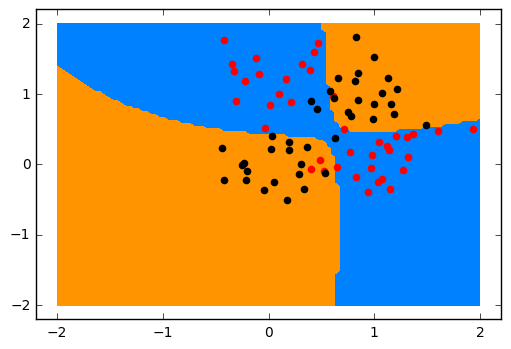

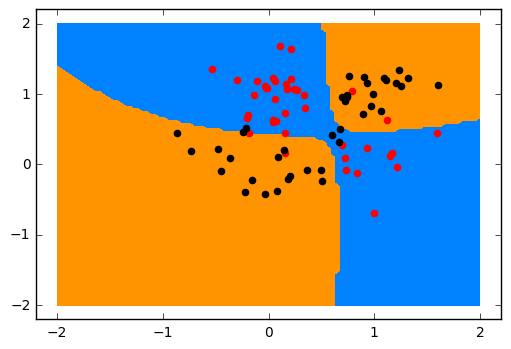

In [6]:
X_train,y_train = create_data(80)
X_test,y_test = create_data(80)

# train svm
c_svm = svm.SVC()
c_svm.fit(X_train,y_train)



#predict test data
y_pred = c_svm.predict(X_test)

# calculate classification error
error = loss_error(y_test,y_pred)
print error

grid_plot_svm(X_train,y_train,100,-2,2,True, X_test,y_test)
grid_plot_svm(X_train,y_train,100,-2,2)

# Exercise H8.3: C-SVM parameter optimization

In [7]:
def m_sq_error(y, y_pred):
    '''
    Synopsis:
        mse = m_sq_error(y, y_pred)
    Arguments:
        y:        Vector of true labels
        y_pred:   Vector of predicted labels
    Output:
        mse:      The mean squared error
    '''
    return ((y_pred - y)**2).mean()

In [8]:
def cross_validation_svm(X, y, L,C, n_folds=10):
    '''
    Synopsis:
        w_opt, b_opt, lambda_opt = cross_validation(X, Y, L,C n_folds=10)
    Arguments:
        X:            2D array of data (features x samples)
        Y:            Vector of true labels (1 x samples)
        L:            List of lambdas to cross validate (1 x #lambdas)
        c:            factor C
        n_folds:      Number of nested folds
    Output:
        c_opt:        optimal C
        l_opt:        optimal lambda
        
        
    '''
    X = X.T
    y = y.T

    d, n = X.shape
    samples_per_fold = int(n / n_folds)
    
    # set up a container for the resulting mse values (n_folds x lambdas)
    MSE = np.empty((n_folds, L.shape[0]))
    loss = np.empty((n_folds, L.shape[0]))
    mse_min = float('inf')
    lambda_opt = 0
    mins = np.empty((C.shape[0],1))
    optis = np.empty((C.shape[0],1))
    
    MSE_means = np.empty((C.shape[0],L.shape[0]))
    
    for k,c in enumerate(C):
        for i, l in enumerate(L):
            # loop over all possible lambdas
            # using different permutation of samples
            idx = np.arange(n) # np.random.permutation(n) # np.arange(n)
            for j in range(n_folds):
                # extract one fold for testing
                idx_te = idx[j*samples_per_fold:(j+1)*samples_per_fold]
                # get the train data
                X_tr = np.delete(X, idx_te, axis=1)
                y_tr = np.delete(y, idx_te, axis=1)
                # get the test data
                X_te = X[:,idx_te]
                y_te = y[:,idx_te]
            
                # train the model
                c_svm = svm.SVC(C=c,gamma=l)
                c_svm.fit(X_tr.T,y_tr.T)
                #w, b = train(X_tr, y_tr, l)
                # predict the label
                y_pred = c_svm.predict(X_tr.T)
                # and compute the mse for this lambda and fold
                MSE[j,i] = m_sq_error(y_tr, y_pred)
                loss[j,i] = loss_error(y_tr,y_pred)

            # find the lambda with the lowest MSE
            mse_this = MSE[:,i].mean()
            MSE_means[k,i] = loss[:,i].mean()
            if(mse_this < mse_min):
                mse_min = mse_this
                lambda_opt = l
                mins[k] = mse_min
                optis[k] = lambda_opt
         
    loc_min = 100000000000   
    opt_lam = 0

    for l,_ in enumerate(mins):
        if (mins[l] < loc_min):
            loc_min = mins[l]
            opt_lam = optis[l]

    return float(opt_lam),float(C[l]),MSE_means

In [9]:
 def grid_plot_svm_2 (X,y,grid_size,r1,r2,l,c, use_own=False, title=''):
    # create a grid for the contour plot
    ran = np.linspace(r1, r2, grid_size)
    GX, GY = np.meshgrid(ran, ran)
    classes = np.zeros((grid_size, grid_size))
    if(use_own):
        c_svm = svm.SVC(C=c,gamma=l)
    else:
        c_svm = svm.SVC()
    c_svm.fit(X,y)

    # go through grid and compute the assigned class
    for gx in range(grid_size):
        for gy in range(grid_size):
            loc = np.vstack((ran[gx],ran[gy])).T
            classes[gx,gy] = c_svm.predict(loc)


    plt.figure()
    plt.contourf(GX, GY, classes[:,:].T, levels=[-1.0,0.,1.0])
    N = len(X[:,0])
    n = N/2
    plt.scatter(X[0:n,0], X[0:n,1], color ='red')
    plt.scatter(X[n+1:N,0], X[n+1:N,1], color='black')
    plt.title(title)


## (a) (2 points) Use cross-validation and grid-search to determine good values for C and the kernel parameter γ. 

Follow the procedure described in the guide: 
Define the grid us- ing exponentially growing sequences of C and γ, e.g. C ∈ {2−6, 2−4, . . . , 210}, γ ∈ {2−5, 2−3, . . . , 29}. 

Make sure you only use the training data in this step. 
Plot the mean training-set classification rate and cross-validation performance as a function of C and γ (e.g. using contour plots as in figure 2 of the guide).

In [166]:
from sklearn.model_selection import cross_val_score

In [167]:
def cross_valid(X, y, c, g, n_folds=10):
    '''
    Synopsis:
        w_opt, b_opt, lambda_opt = cross_validation(X, Y, L, n_folds=10)
    Arguments:
        X:            2D array of data (features x samples)
        Y:            Vector of true labels (1 x samples)
        L:            List of lambdas to cross validate (1 x #lambdas)
        n_folds:      Number of nested folds
    Output:
        w_opt:        optimal weight vector
        b_opt:        optimal bias
        lambda_opt:   the lambda with the lowest MSE
    '''
    X = X.T
    y = y.T
    d, n = X.shape
    samples_per_fold = int(float(n)/ float(n_folds))

    rates = np.empty(n_folds)
    idx = np.arange(n) # np.random.permutation(n) # np.arange(n)
    for j in range(n_folds):
        # extract one fold for testing
        idx_te = idx[j*samples_per_fold:(j+1)*samples_per_fold]
        # get the train data
        X_tr = np.delete(X, idx_te, axis=1)
        y_tr = np.delete(y, idx_te, axis=1)
        # get the test data
        X_te = X[:,idx_te]
        y_te = y[:,idx_te]

        
        # train the model
        c_svm = svm.SVC(C=c,gamma=g)
        c_svm.fit(X_tr.T,y_tr.T)
        # predict the label
        y_pred = c_svm.predict(X_te.T)
        
        rates[j] = float(loss_error(y_te.T,y_pred))
    
    return np.min(rates)

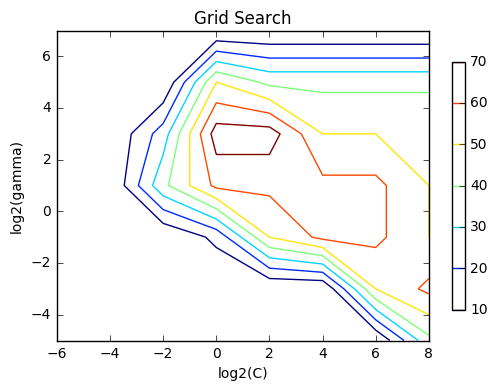

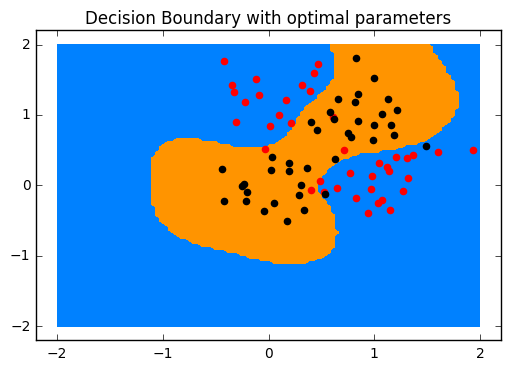

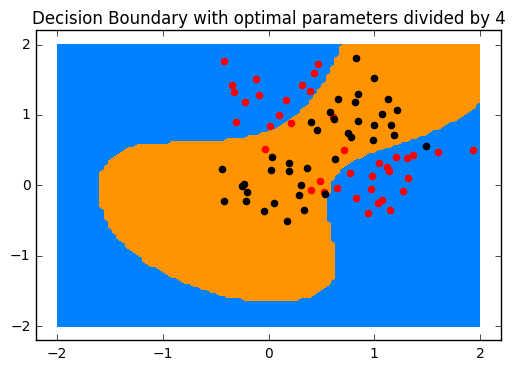

In [169]:
X_train,y_train = create_data(80)
C = 2.**np.arange(-6,10,2)
G = 2.**np.arange(-5,9,2)

rates = np.zeros((C.shape[0],G.shape[0]))
best_c = 0
best_g = 0
best_rate = 0
for i,c in enumerate(C):
    for j,g in enumerate(G):
        rates[i,j] = cross_valid(X_train,y_train,c,g)
        if (rates[i,j] > best_rate):
            best_rate = rates[i,j];
            best_c = c
            best_g = g
            
        
CS = plt.contour(np.log2(C),np.log2(G),rates.T)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.xlabel('log2(C)')
plt.ylabel('log2(gamma)')
plt.title('Grid Search')
plt.show()


grid_plot_svm_2(X_test,y_test,100,-2,2,best_g,best_c,True,"Decision Boundary with optimal parameters")
grid_plot_svm_2(X_test,y_test,100,-2,2,float(best_g)/float(4),float(best_c)/float(4),True,"Decision Boundary with optimal parameters divided by 4")




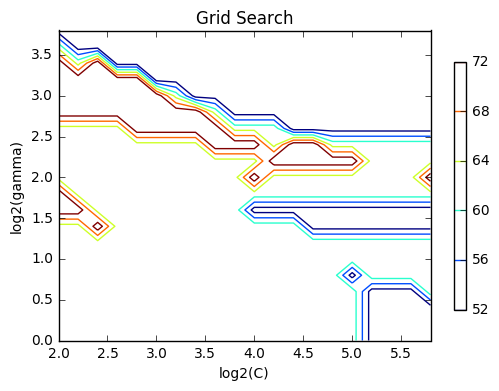

In [170]:
C2 = 2.**np.arange(2,6,0.2)
G2 = 2.**np.arange(0,4,0.2)

rates2 = np.zeros((C2.shape[0],G2.shape[0]))
best_c2 = 0
best_g2 = 0
best_rate2 = 0
for k,c2 in enumerate(C2):
    for l,g2 in enumerate(G2):
        rates2[k,l] = cross_valid(X_train,y_train,c2,g2)
        if (rates2[k,l] > best_rate2):
            best_rate2 = rates2[k,l];
            best_c2 = c2
            best_g2 = g2
            
CS = plt.contour(np.log2(C2),np.log2(G2),rates2.T)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.xlabel('log2(C)')
plt.ylabel('log2(gamma)')
plt.title('Grid Search')
plt.show()